In [469]:
NUMBER_OF_EPOCH = 5000
# num_of_categories = 

In [470]:
import torch
import torch.nn as nn
import pandas as pd
import math
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
elif torch.backends.cuda.is_built():
    mps_device = torch.device("cuda")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='cuda:0')


In [471]:
def prepare_model(df):
    
    # df = pre.standardize(df)
    # df = pre.encoder(df)
    # df = df.drop(['id'], axis=1)

    from sklearn.model_selection import train_test_split
    train, val = train_test_split(df, test_size=0.10)

    y_train = torch.tensor(train['price'].values, dtype=torch.float32)
    X_train = train.drop(['price'], axis=1)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)

    y_val = torch.tensor(val['price'].values, dtype=torch.float32)
    X_val = val.drop(['price'], axis=1)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
        
    return X_train, y_train, X_val, y_val

In [472]:
# Define model
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Linear(8, 2048),
        nn.Dropout(0.25),
        nn.ReLU(), 

        nn.Linear(2048, 1024),
        nn.ReLU(), 
        
        nn.Linear(1024, 1)
        )
        
        self.model_layer = nn.Sequential(
        nn.Linear(165, 1),
        nn.ReLU()
        )
        
        self.gear_box_layer = nn.Sequential(
        nn.Linear(3, 1),
        nn.ReLU()
        )
        
        self.fuel_type_layer = nn.Sequential( 
        nn.Linear(5, 1),
        nn.ReLU()
        )
        
        # self.registration_fee_layer = nn.Sequential(
        # nn.Linear(8, 1),
        # nn.ReLU()
        # )
        
        # self.engine_capacity_layer = nn.Sequential(
        # nn.Linear(10, 1),
        # nn.ReLU()
        # )
    
        
    def forward(self, x):
        # print(x.shape)
        model = self.model_layer(x[:, 5:170])
        gear_box = self.gear_box_layer(x[:, 170:173])
        fuel_type = self.fuel_type_layer(x[:, 173:178])
        
        # registration_fee = self.registration_fee_layer(x[:, 156:164])
        # engine_capacity = self.engine_capacity_layer(x[:, 164:174])
        # operating_hours = x[:, 174].view(-1, 1)
        # year = x[:, 175].view(-1, 1)
        # efficiency = x[:, 176].view(-1, 1)

        
        # x = torch.cat((model, year, gear_box, operating_hours, fuel_type, registration_fee, efficiency, engine_capacity), 1)
        
        x = torch.cat((model, gear_box, fuel_type, x[:, :5]), 1)
        
        return self.layers(x)

model = mlp()
model

mlp(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=2048, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1024, out_features=1, bias=True)
  )
  (model_layer): Sequential(
    (0): Linear(in_features=165, out_features=1, bias=True)
    (1): ReLU()
  )
  (gear_box_layer): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): ReLU()
  )
  (fuel_type_layer): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): ReLU()
  )
)

In [473]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [474]:
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [475]:
df = pd.read_csv('data/train.csv')
X_train, y_train, X_val, y_val = prepare_model(df)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

torch.Size([8910, 178]) torch.Size([8910]) torch.Size([990, 178]) torch.Size([990])


In [476]:
import numpy as np 
best_val_loss = float('inf')
training_loss = np.array([])
validation_loss = np.array([])
last_val_loss = float('inf')
count = 0
for n in range(NUMBER_OF_EPOCH):
    model.train()
    y_pred = model(X_train)[:, 0]
    loss = loss_fn(y_pred, y_train)
    training_loss = np.append(training_loss, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    y_pred = model(X_val)[:, 0]
    val_loss = loss_fn(y_pred, y_val).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'mlp_model.pth')
        
    y_pred = model(X_train)[:, 0]
    training_loss_eval = loss_fn(y_pred, y_train).item()
    
    if n % 100 == 0:
        print(f'Epoch: {n} Training loss:  {training_loss_eval}'f' Validation loss: {val_loss}'f' best Validation loss: {best_val_loss}')
        
    if last_val_loss < val_loss:
        count += 1
        if count == 25:
            break
    else:
        count = 0
    last_val_loss = val_loss
    
torch.save(model, 'mlp_model.pth')

Epoch: 0 Training loss:  19081.587890625 Validation loss: 19183.76171875 best Validation loss: 19183.76171875
Epoch: 100 Training loss:  6590.078125 Validation loss: 6582.10791015625 best Validation loss: 6582.10791015625
Epoch: 200 Training loss:  4160.3115234375 Validation loss: 3798.714111328125 best Validation loss: 3798.714111328125
Epoch: 300 Training loss:  3564.72607421875 Validation loss: 3285.710693359375 best Validation loss: 3285.710693359375
Epoch: 400 Training loss:  3105.0 Validation loss: 2884.4677734375 best Validation loss: 2884.4677734375
Epoch: 500 Training loss:  2747.712890625 Validation loss: 2583.17919921875 best Validation loss: 2583.17919921875
Epoch: 600 Training loss:  2584.527587890625 Validation loss: 2461.974365234375 best Validation loss: 2461.974365234375
Epoch: 700 Training loss:  2515.269775390625 Validation loss: 2405.78759765625 best Validation loss: 2405.78759765625
Epoch: 800 Training loss:  2480.41796875 Validation loss: 2376.4873046875 best Vali

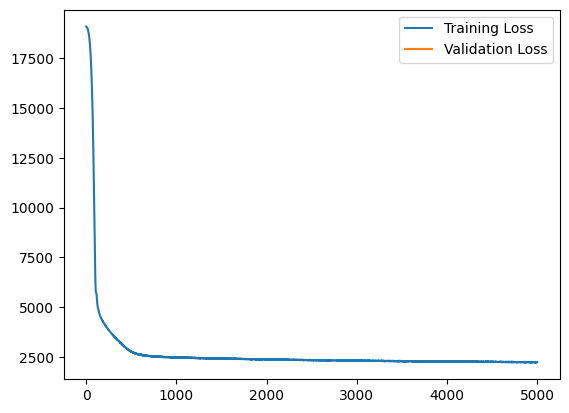

In [477]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')

In [478]:
df = pd.read_csv('data/test.csv')
model = torch.load('mlp_model.pth')
model.eval()

index = df['id']
# X = pre.encoder(df)
# X = pre.standardize(X, scaler=pickle.load(open('scaler.pkl', 'rb')))
X = df.drop(['id'], axis=1)
X = torch.tensor(X.values, dtype=torch.float32)
y_pred = model(X)[:, 0]

df = pd.DataFrame(y_pred.detach().numpy(), columns=['price'])
df = pd.concat([index, df], axis=1)
df.rename(columns={'price': 'answer'}, inplace=True)
df.to_csv('output.csv', index=False)

/tmp/ipykernel_6045/1189036708.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mlp_model.pth')
